In [14]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

In [64]:
print(sorted(scaffold['CDK2'].keys()), len(scaffold['CDK2'].keys()))
print(sorted(rmsds['CDK2'].keys()), len(rmsds['CDK2'].keys()))

['1AQ1', '1CKP', '1DI8', '1DM2', '1E1V', '1E1X', '1E9H', '1FIN', '1FVT', '1FVV', '1G5S', '1GIH', '1GIJ', '1GZ8', '1H0V', '1H1Q', '1H1R', '1H1S', '1JSV', '1JVP', '1KE5', '1KE6', '1KE7', '1KE8'] 24
['1PYE', '1W0X', '1YKR', '2EXM', '2VV9', '2W05', '2W06', '2WXV', '2XMY', '2XNB', '3EJ1', '3QL8', '3QRT', '3QRU', '3RAH', '3RAI', '3RAK', '3RAL', '4BZD', '4EOI', '4FKG', '4FKI', '4FKJ', '4FKO', '5IEV'] 25


In [65]:
print(sorted(scaffold.keys()))

['5HT2B', 'A2AR', 'AR', 'B1AR', 'B2AR', 'BACE1', 'BRAF', 'BRD4', 'CDK2', 'CHK1', 'CHRM3', 'D2', 'DAT', 'DHFR', 'ELANE', 'ERA', 'F10', 'F11', 'F2', 'GLUT1', 'HSP90AA1', 'JAK2', 'MAPK14', 'MEK1', 'MGLUR5', 'NR3C1', 'NR3C2', 'P00760', 'PDE10A', 'PLAU', 'PLK1', 'PTPN1', 'PYGM', 'SIGMAR1', 'SLC6A4', 'SMO', 'TRPV1', 'VDR']


In [102]:
scaffold = {}
size = {}
for protein_file in glob.glob('../../similarity/Data/mcss/*_mcss.csv'):
    protein = protein_file.replace('../../similarity/Data/mcss/','').replace('_mcss.csv','')
    scaffold[protein] = {}
    size[protein] = {}
    with open(protein_file) as f:
        lines = f.readlines()
        for l in lines[1:]:
            tokens = l.split(',')
            valid = int(tokens[4]) > 0.4*min(int(tokens[3]), int(tokens[2]))
            if tokens[0] not in scaffold[protein]: 
                scaffold[protein][tokens[0]] = {}
                
            scaffold[protein][tokens[0]][tokens[1]] = valid
            
            if tokens[0] not in size[protein]:
                size[protein][tokens[0]] = {}
            if tokens[1] not in size[protein]:
                size[protein][tokens[1]] = {}
            size[protein][tokens[0]] = int(tokens[2])
            size[protein][tokens[1]] = int(tokens[3])  
                

In [125]:
def overall_stats(rmsd_select_func):
    #keeping track of totals
    self_counter = 0
    cross_counter = 0
    error_counter = 0
    cross_diff_counter = 0
    cross_size_counter = 0
    #keeping track of correct
    self_docking_count = 0
    cross_docking_count = 0
    cross_docking_diff_count = 0
    cross_docking_size_count = 0
    
    #keeping track of rmsd
    self_docking_sum = 0
    cross_docking_sum = 0

    cross_docking_min = sys.maxsize
    cross_docking_max = -sys.maxsize
    min_protein = ''
    min_ligand = ''
    min_struc = ''
    max_protein = ''
    max_ligand = ''
    max_struc = ''

    for protein in rmsds:
        if protein == 'A2AR': continue 
        for struc in rmsds[protein]:
            for ligand in rmsds[protein][struc]:
                
                #error on rmsd calculation -> don't include data
                if rmsds[protein][struc][ligand] == []:
                    error_counter += 1
                    continue
                
                #Couldn't generate any poses 
                if rmsds[protein][struc][ligand] == None:
                    if ligand == struc:
                        self_counter += 1
                    else:
                        cross_counter += 1
                        if size[protein][ligand] > 1.5*size[protein][struc]:
                            cross_size_counter += 1
                        keys = sorted([struc,ligand])
                        if not scaffold[protein][keys[0]][keys[1]]:
                            cross_diff_counter += 1
                    continue
                
                #could generate poses
                rmsd = rmsd_select_func(rmsds[protein][struc][ligand])
                if ligand == struc:
                    #self docking
                    self_counter += 1
                    self_docking_sum += rmsd
                    if rmsd < 2:
                        self_docking_count += 1
                else:
                    #cross docking
                    cross_counter += 1
                    cross_docking_sum += rmsd
                    if rmsd < 2:
                        cross_docking_count += 1
                    if rmsd < cross_docking_min:
                        cross_docking_min = rmsd
                        min_protein = protein
                        min_struc = struc
                        min_ligand = ligand
                    if rmsd > cross_docking_max:
                        cross_docking_max = rmsd
                        max_protein = protein
                        max_struc = struc
                        max_ligand = ligand
                    #different scaffolds
                    keys = sorted([struc,ligand])
                    if not scaffold[protein][keys[0]][keys[1]]:
                        cross_diff_counter += 1
                        if rmsd < 2:
                            cross_docking_diff_count += 1
                            
                    if size[protein][ligand] > 1.5*size[protein][struc]:
                        cross_size_counter += 1
                        if rmsd < 2:
                            cross_docking_size_count += 1
                        

    results = {'Self Docking Accuracy': self_docking_count * 100 / self_counter,
              'Cross Docking Accuracy': cross_docking_count * 100 / cross_counter,
              'Cross Docking Diff Accuracy': cross_docking_diff_count * 100 / cross_diff_counter,
              'Cross Docking Bigger Accuracy': cross_docking_size_count * 100 / cross_size_counter,
              'Number Pairs with Different': (cross_diff_counter, cross_counter),
              'Number Pairs with Bigger': (cross_size_counter, cross_counter),
              'Number Pairs for self,cross': (self_counter, cross_counter),
              'errors': (error_counter, self_counter + cross_counter)}                
    
    '''
    print("Self Docking Average RMSD: ", self_docking_sum / self_counter)
    print("Cross Docking Average RMSD: ", cross_docking_sum / cross_counter)
    print("Cross Docking Min RMSD:", cross_docking_min, "protein:", min_protein, "struc:", min_struc, "ligand:", min_ligand)
    print("Cross Docking Max RMSD:", cross_docking_max, "protein:", max_protein, "struc:", max_struc, "ligand:", max_ligand)
    
    print("Self Docking Average RMSD: ", self_docking_sum / self_counter)
    print("Cross Docking Average RMSD: ", cross_docking_sum / cross_counter)
    print("Cross Docking Min RMSD:", cross_docking_min, "protein:", min_protein, "struc:", min_struc, "ligand:", min_ligand)
    print("Cross Docking Max RMSD:", cross_docking_max, "protein:", max_protein, "struc:", max_struc, "ligand:", max_ligand)
    '''
    return results  

In [126]:
#infile = open('../Data/rmsds','rb')
#rmsds = pickle.load(infile)
#infile.close()

infile = open('../Data/rmsds_all.pkl','rb')
rmsds = pickle.load(infile)
infile.close()

#rmsds.update(rmsds_2)

# rmsd is structured as such
# outter most dictionary: key = protein, val = dictionary2
# dictionary2: key = struc, val = dictionary3
# dictionary3: key = ligand, val = list of rmsds for the top 100 glide poses 
import pprint

pp = pprint.PrettyPrinter(indent=4)

rmsd_select_func = lambda x: x[0]
top_stats = overall_stats(rmsd_select_func)
print("Evaluating Top Glide Pose: ")
pp.pprint(top_stats)

rmsd_select_func = lambda x: min(x)
all_stats = overall_stats(rmsd_select_func)
print("Evaluating All Glide Poses: ")
pp.pprint(all_stats)



Evaluating Top Glide Pose: 
{   'Cross Docking Accuracy': 41.82108140947752,
    'Cross Docking Bigger Accuracy': 20.474406991260924,
    'Cross Docking Diff Accuracy': 31.75033921302578,
    'Number Pairs for self,cross': (637, 13168),
    'Number Pairs with Bigger': (1602, 13168),
    'Number Pairs with Different': (7370, 13168),
    'Self Docking Accuracy': 76.29513343799059,
    'errors': (13, 13805)}
Evaluating All Glide Poses: 
{   'Cross Docking Accuracy': 65.53766707168894,
    'Cross Docking Bigger Accuracy': 41.57303370786517,
    'Cross Docking Diff Accuracy': 56.87924016282225,
    'Number Pairs for self,cross': (637, 13168),
    'Number Pairs with Bigger': (1602, 13168),
    'Number Pairs with Different': (7370, 13168),
    'Self Docking Accuracy': 90.42386185243328,
    'errors': (13, 13805)}


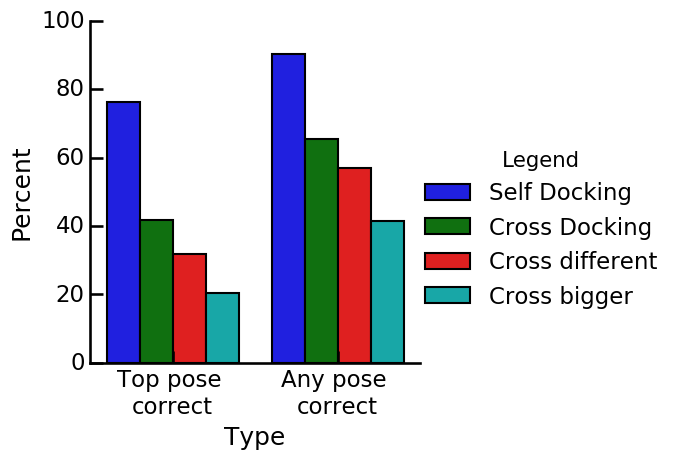

In [144]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_context("talk", font_scale=1.0)
unnormalized_all_graph_rmsds = []

label1 = 'Top pose \ncorrect'
label2 = 'Any pose \ncorrect'
unnormalized_all_graph_rmsds.append([label1, top_stats['Self Docking Accuracy'], 'Self Docking'])
unnormalized_all_graph_rmsds.append([label1, top_stats['Cross Docking Accuracy'], 'Cross Docking'])
unnormalized_all_graph_rmsds.append([label1, top_stats['Cross Docking Diff Accuracy'], 'Cross different'])
unnormalized_all_graph_rmsds.append([label1, top_stats['Cross Docking Bigger Accuracy'], 'Cross bigger'])

unnormalized_all_graph_rmsds.append([label2, all_stats['Self Docking Accuracy'], 'Self Docking'])
unnormalized_all_graph_rmsds.append([label2, all_stats['Cross Docking Accuracy'], 'Cross Docking'])
unnormalized_all_graph_rmsds.append([label2, all_stats['Cross Docking Diff Accuracy'], 'Cross different'])
unnormalized_all_graph_rmsds.append([label2, all_stats['Cross Docking Bigger Accuracy'], 'Cross bigger'])

df = pd.DataFrame(unnormalized_all_graph_rmsds)
df.columns= ['Type', 'Percent', 'Legend']
g = sns.catplot(x='Type', y='Percent', hue='Legend', data=df, kind="bar")
#plt.title('Unormalized')
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.show()

In [193]:
import statistics

def stat_finder(protein, rmsd_select_func):
    #keeping track of totals
    self_counter = 0
    cross_counter = 0
    error_counter = 0
    cross_diff_counter = 0
    cross_size_counter = 0
    #keeping track of correct
    self_docking_count = 0
    cross_docking_count = 0
    cross_docking_diff_count = 0
    cross_docking_size_count = 0
    
    #keeping track of rmsd
    self_docking_sum = 0
    cross_docking_sum = 0

    cross_docking_min = sys.maxsize
    cross_docking_max = -sys.maxsize
    min_protein = ''
    min_ligand = ''
    min_struc = ''
    max_protein = ''
    max_ligand = ''
    max_struc = ''

    for struc in rmsds[protein]:
        for ligand in rmsds[protein][struc]:
            #error on rmsd calculation -> don't include data
            if rmsds[protein][struc][ligand] == []:
                error_counter += 1
                continue

            #Couldn't generate any poses 
            if rmsds[protein][struc][ligand] == None:
                if ligand == struc:
                    self_counter += 1
                else:
                    cross_counter += 1
                    if size[protein][ligand] > 1.5*size[protein][struc]:
                        cross_size_counter += 1
                    keys = sorted([struc,ligand])
                    if not scaffold[protein][keys[0]][keys[1]]:
                        cross_diff_counter += 1
                continue

            #could generate poses
            rmsd = rmsd_select_func(rmsds[protein][struc][ligand])
            if ligand == struc:
                #self docking
                self_counter += 1
                self_docking_sum += rmsd
                if rmsd < 2:
                    self_docking_count += 1
            else:
                #cross docking
                cross_counter += 1
                cross_docking_sum += rmsd
                if rmsd < 2:
                    cross_docking_count += 1
                if rmsd < cross_docking_min:
                    cross_docking_min = rmsd
                    min_protein = protein
                    min_struc = struc
                    min_ligand = ligand
                if rmsd > cross_docking_max:
                    cross_docking_max = rmsd
                    max_protein = protein
                    max_struc = struc
                    max_ligand = ligand
                #different scaffolds
                keys = sorted([struc,ligand])
                if not scaffold[protein][keys[0]][keys[1]]:
                    cross_diff_counter += 1
                    if rmsd < 2:
                        cross_docking_diff_count += 1

                if size[protein][ligand] > 1.5*size[protein][struc]:
                    cross_size_counter += 1
                    if rmsd < 2:
                        cross_docking_size_count += 1

    return {'self_accuracy' : self_docking_count * 100 / self_counter if self_counter else None,
            'cross_accuracy' : cross_docking_count * 100 / cross_counter if cross_counter else None,
            'cross_diff_accuracy': cross_docking_diff_count * 100 / cross_diff_counter if cross_diff_counter else None,
            'cross_bigger_accuracy': cross_docking_size_count * 100 / cross_size_counter if cross_size_counter else None,
            'self_avg' : self_docking_sum / self_counter if self_counter else None,
            'cross_avg' : cross_docking_sum / cross_counter if cross_counter else None}

print("Evaluating Stats for each protein normalized, top: ")
top_stats = {}
top_func = lambda x: x[0]
for protein in rmsds:
    if protein == 'A2AR': continue 
    top_stats[protein] = stat_finder(protein, top_func)

top_stats_aggregated = {}
for protein in top_stats:
    for stat in ['self_accuracy','cross_accuracy','cross_diff_accuracy','cross_bigger_accuracy']:
        if not top_stats[protein][stat] == None:
            if stat not in top_stats_aggregated:
                top_stats_aggregated[stat] = []
                
            top_stats_aggregated[stat].append(top_stats[protein][stat])

for stat in ['self_accuracy','cross_accuracy','cross_diff_accuracy','cross_bigger_accuracy']:
    print(stat, statistics.mean(top_stats_aggregated[stat]))

print("Evaluating Stats for each protein normalized, any: ")
any_stats = {}
any_func = lambda x: min(x)
for protein in rmsds:
    if protein == 'A2AR': continue 
    any_stats[protein] = stat_finder(protein, any_func)

any_stats_aggregated = {}
for protein in any_stats:
    for stat in ['self_accuracy','cross_accuracy','cross_diff_accuracy','cross_bigger_accuracy']:
        if not any_stats[protein][stat] == None:
            if stat not in any_stats_aggregated:
                any_stats_aggregated[stat] = []
                
            any_stats_aggregated[stat].append(any_stats[protein][stat])

for stat in ['self_accuracy','cross_accuracy','cross_diff_accuracy','cross_bigger_accuracy']:
    print(stat, statistics.mean(any_stats_aggregated[stat]))


Evaluating Stats for each protein normalized, top: 
self_accuracy 75.2565485653721
cross_accuracy 40.522185619648475
cross_diff_accuracy 31.97397888044603
cross_bigger_accuracy 17.77049176113803
Evaluating Stats for each protein normalized, any: 
self_accuracy 89.49338203749969
cross_accuracy 67.9200745596322
cross_diff_accuracy 61.39739613603352
cross_bigger_accuracy 38.33079200011955


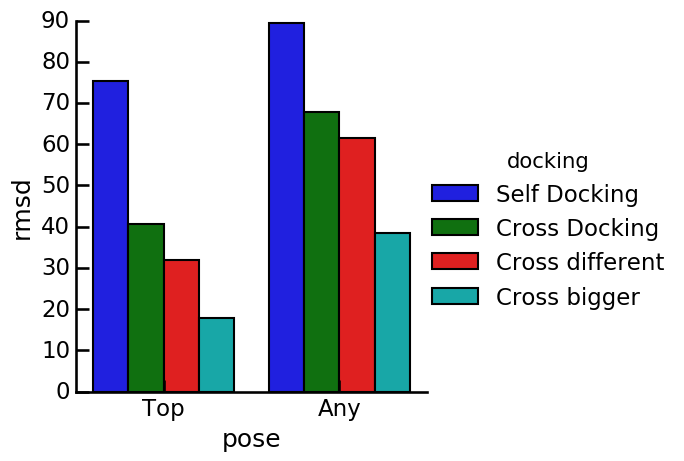

In [194]:
normalized_all_graph_rmsds = []
name = {'self_accuracy':'Self Docking',
        'cross_accuracy':'Cross Docking',
        'cross_diff_accuracy':'Cross different',
        'cross_bigger_accuracy': 'Cross bigger'}
for stat in ['self_accuracy','cross_accuracy','cross_diff_accuracy','cross_bigger_accuracy']:
    normalized_all_graph_rmsds.append(['Top', statistics.mean(top_stats_aggregated[stat]), name[stat]])
for stat in ['self_accuracy','cross_accuracy','cross_diff_accuracy','cross_bigger_accuracy']:
    normalized_all_graph_rmsds.append(['Any', statistics.mean(any_stats_aggregated[stat]), name[stat]])
        
    
df = pd.DataFrame(normalized_all_graph_rmsds)
df.columns= ['pose', 'rmsd', 'docking']
g = sns.catplot(x='pose', y='rmsd', hue='docking', data=df, kind="bar")
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.show()

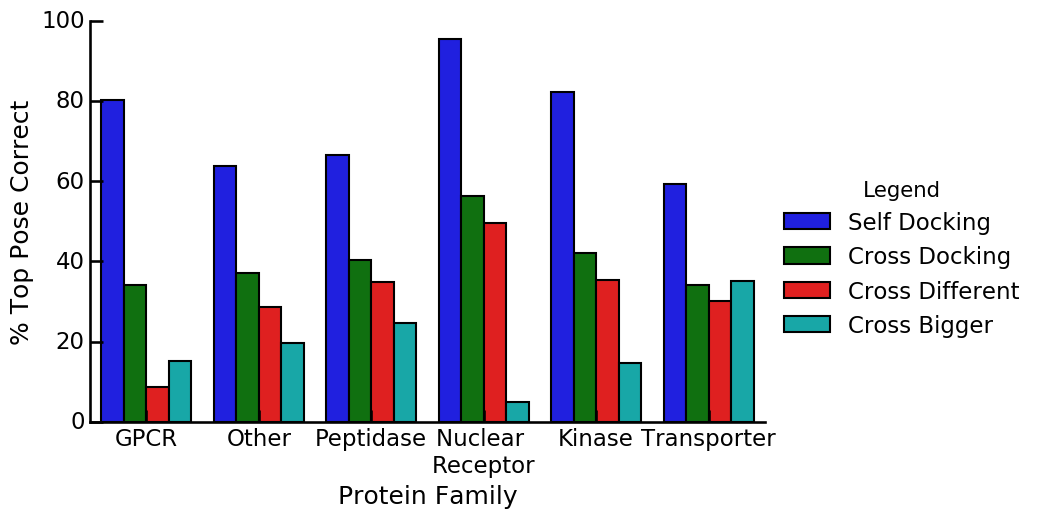

In [211]:
normalized_top_group_graph_rmsds = []
normalized_any_group_graph_rmsds = []

family = {
        'GPCR': ['5HT2B', 'B1AR', 'B2AR', 'CHRM3','SMO', 'MGLUR5'], #'A2AR', 
        'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
        'Transporter': ['SLC6A4', 'GLUT1', 'DAT'],
        'Nuclear \nReceptor': ['NR3C2', 'NR3C1', 'AR', 'VDR', 'ERA'],
        'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
        'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1', 'ELANE', 'TRPV1', 'DHFR']
        }

for group in family:
    top_self_accuracy = []
    top_cross_accuracy = []
    top_cross_diff_accuracy = []
    top_cross_size_accuracy = []
    
    any_self_accuracy = []
    any_cross_accuracy = []
    for protein in family[group]:
        top_self_accuracy.append(top_stats[protein]['self_accuracy'])
        top_cross_accuracy.append(top_stats[protein]['cross_accuracy'])
        if top_stats[protein]['cross_diff_accuracy'] is not None:
            top_cross_diff_accuracy.append(top_stats[protein]['cross_diff_accuracy'])
        if top_stats[protein]['cross_bigger_accuracy'] is not None:
            top_cross_size_accuracy.append(top_stats[protein]['cross_bigger_accuracy'])
        
        any_self_accuracy.append(any_stats[protein]['self_accuracy'])
        any_cross_accuracy.append(any_stats[protein]['cross_accuracy'])
        
    normalized_top_group_graph_rmsds.append([group, statistics.mean(top_self_accuracy), 'Self Docking'])
    normalized_top_group_graph_rmsds.append([group, statistics.mean(top_cross_accuracy), 'Cross Docking'])
    normalized_top_group_graph_rmsds.append([group, statistics.mean(top_cross_diff_accuracy), 'Cross Different'])
    normalized_top_group_graph_rmsds.append([group, statistics.mean(top_cross_size_accuracy), 'Cross Bigger'])
    
    normalized_any_group_graph_rmsds.append([group, statistics.mean(any_self_accuracy), 'Self'])
    normalized_any_group_graph_rmsds.append([group, statistics.mean(any_cross_accuracy), 'Cross'])
    
df = pd.DataFrame(normalized_top_group_graph_rmsds)
ylabel = '% Top Pose Correct'
legend = 'Legend'
xlabel = 'Protein Family'
df.columns= [xlabel, ylabel, legend]
g = sns.catplot(x=xlabel, y=ylabel, hue=legend, data=df, kind="bar", height=8)
#plt.title('Normalized top')

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

fig = plt.gcf()
fig.set_size_inches(11,5)

plt.show()

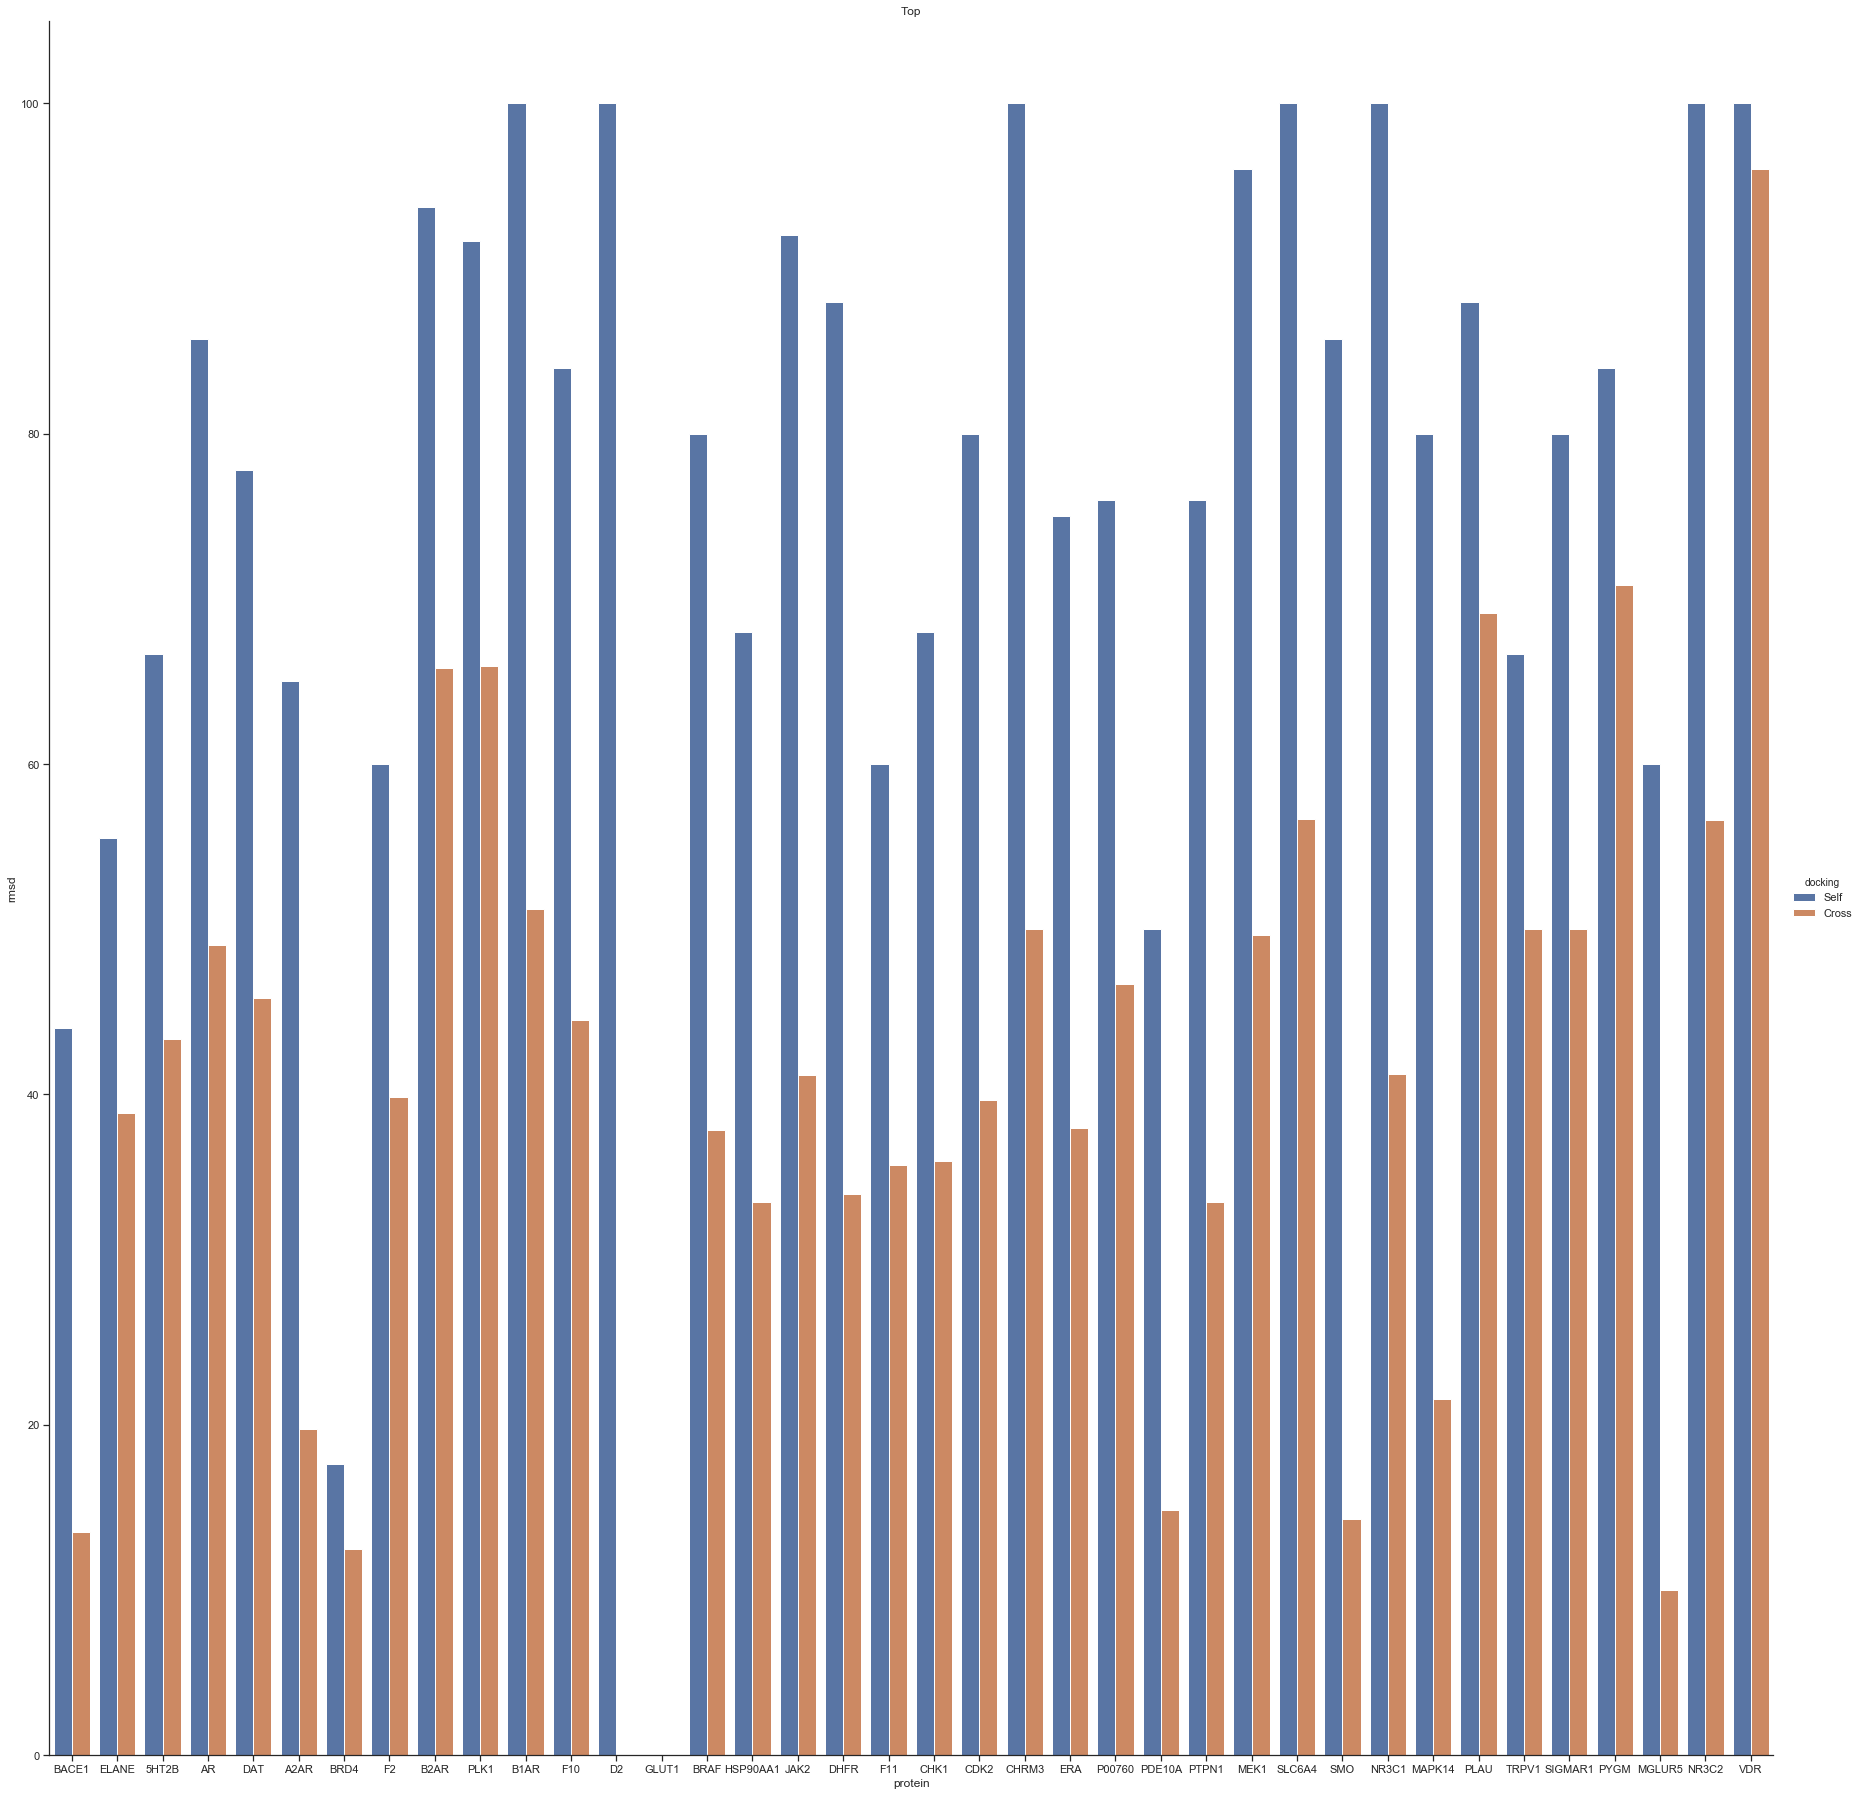

In [85]:
top_protein_graph_rmsds = []
for protein in top_stats:
    top_protein_graph_rmsds.append([protein, top_stats[protein]['self_accuracy'], 'Self'])
    top_protein_graph_rmsds.append([protein, top_stats[protein]['cross_accuracy'], 'Cross'])

df = pd.DataFrame(top_protein_graph_rmsds)
df.columns= ['protein', 'rmsd', 'docking']
g = sns.catplot(x='protein', y='rmsd', hue='docking', data=df, kind="bar", height=25)
plt.title('Top')
plt.show()

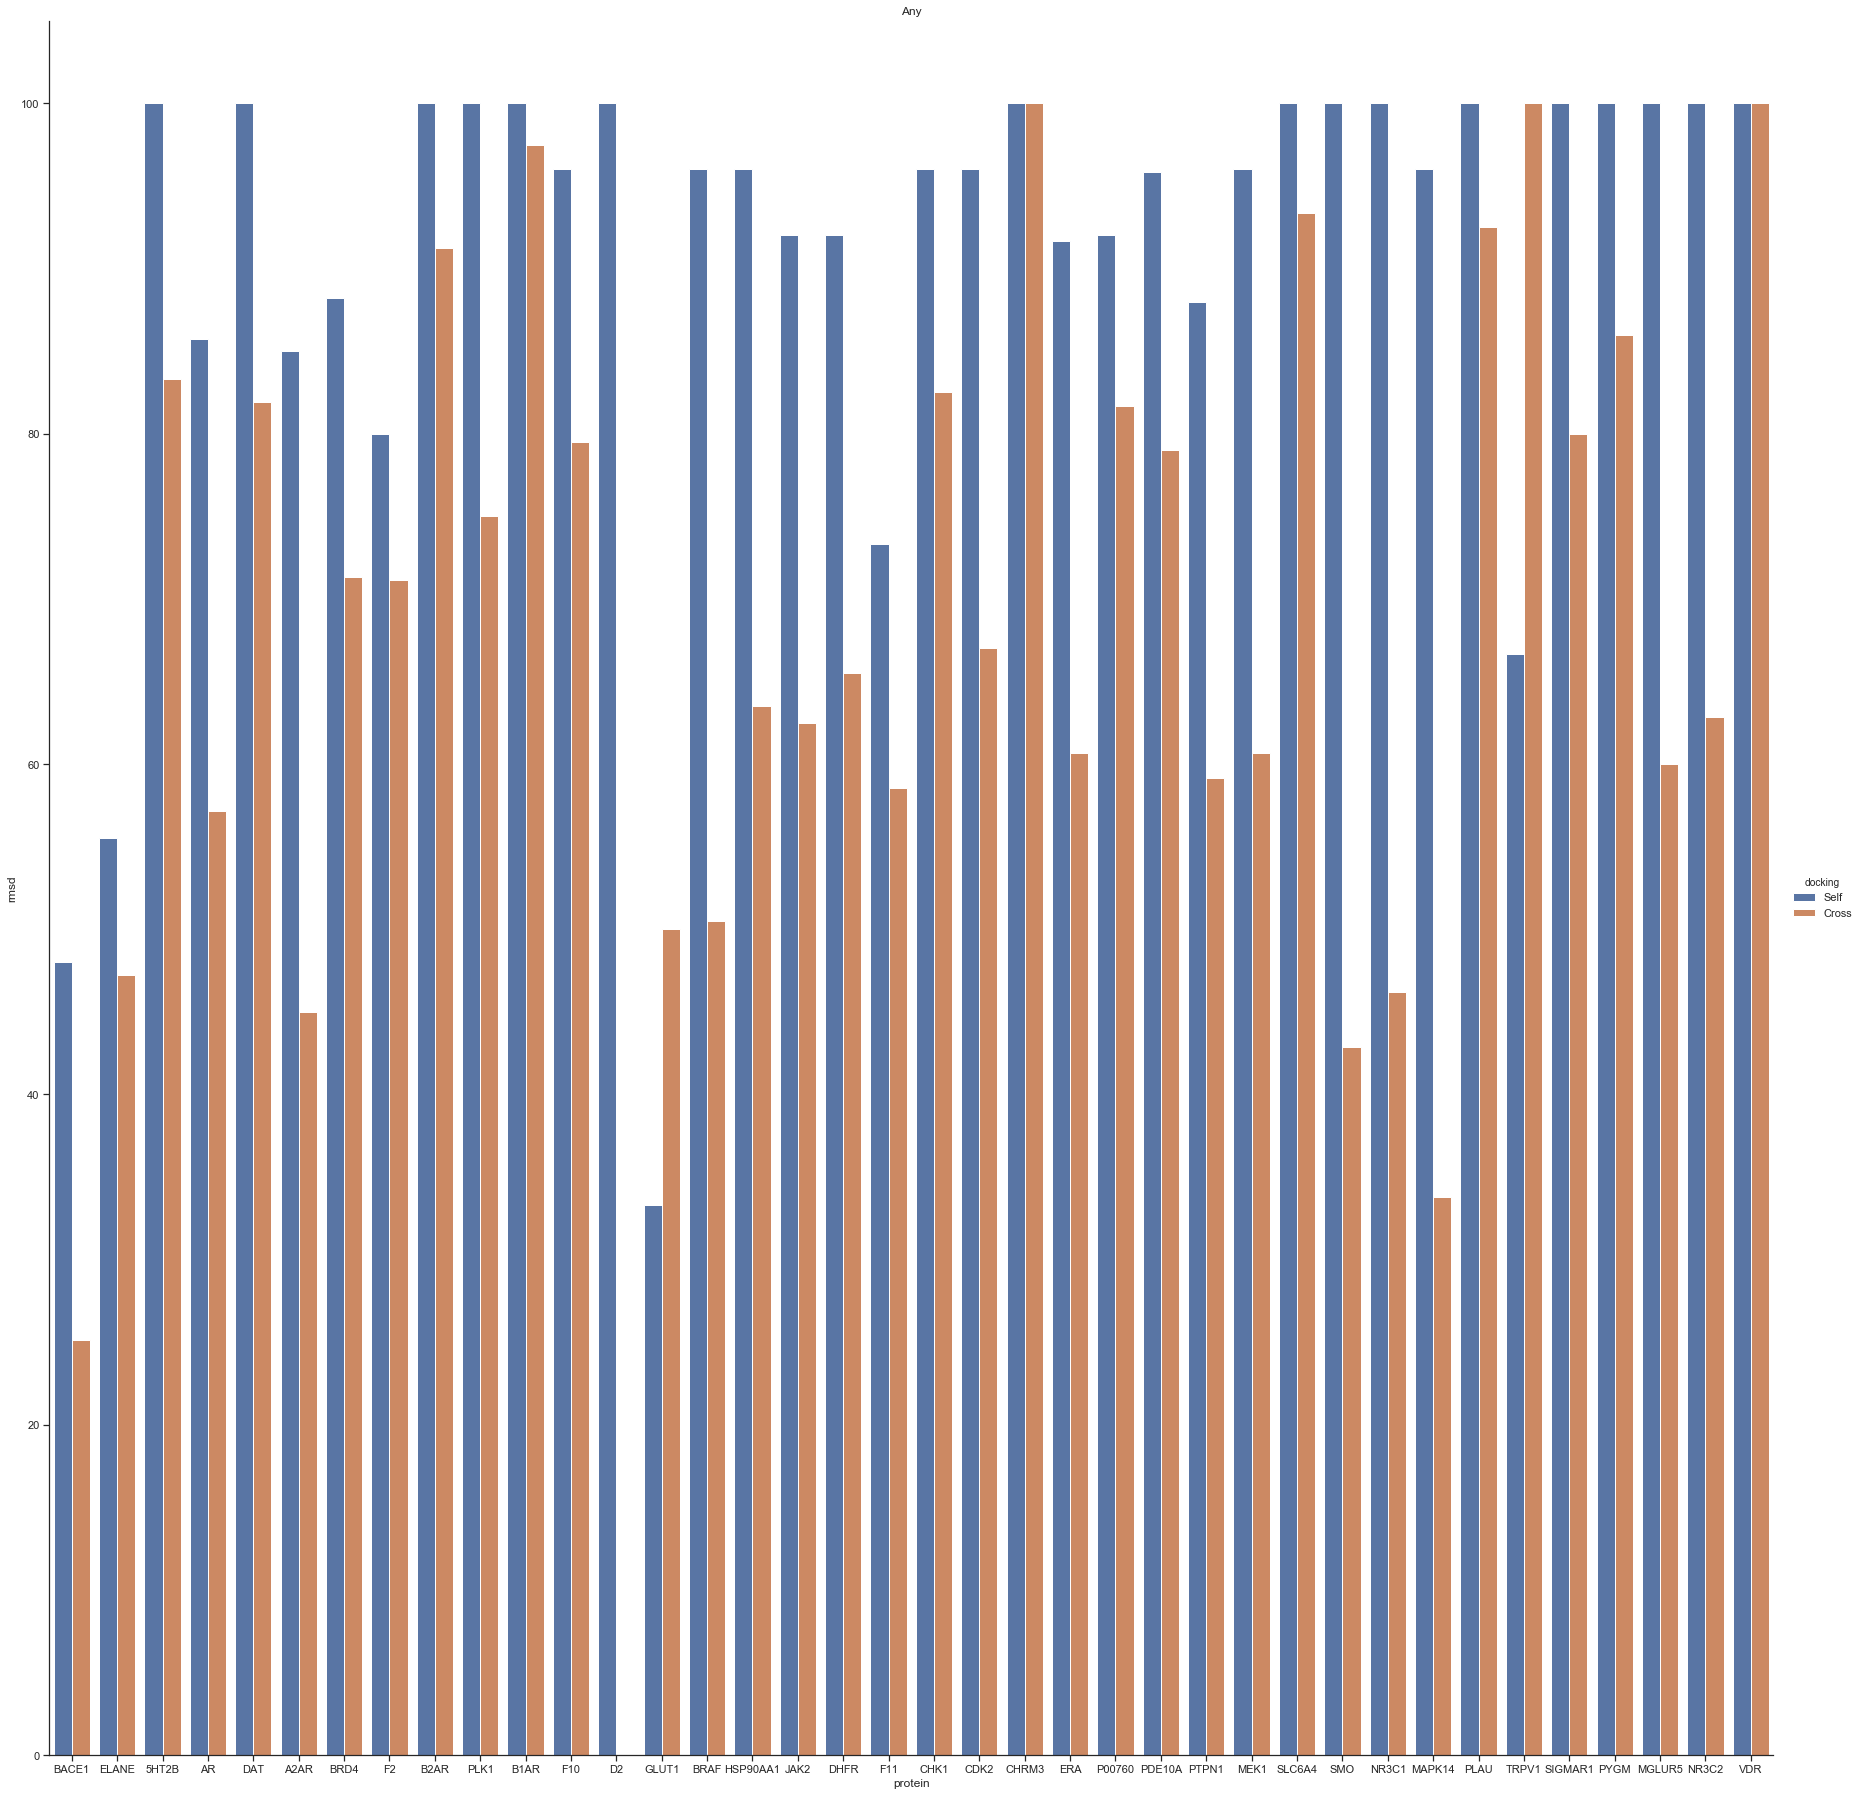

In [86]:
any_protein_graph_rmsds = []
for protein in top_stats:
    any_protein_graph_rmsds.append([protein, any_stats[protein]['self_accuracy'], 'Self'])
    any_protein_graph_rmsds.append([protein, any_stats[protein]['cross_accuracy'], 'Cross'])

df = pd.DataFrame(any_protein_graph_rmsds)
df.columns= ['protein', 'rmsd', 'docking']
g = sns.catplot(x='protein', y='rmsd', hue='docking', data=df, kind="bar", height=25)
plt.title('Any')
plt.show()

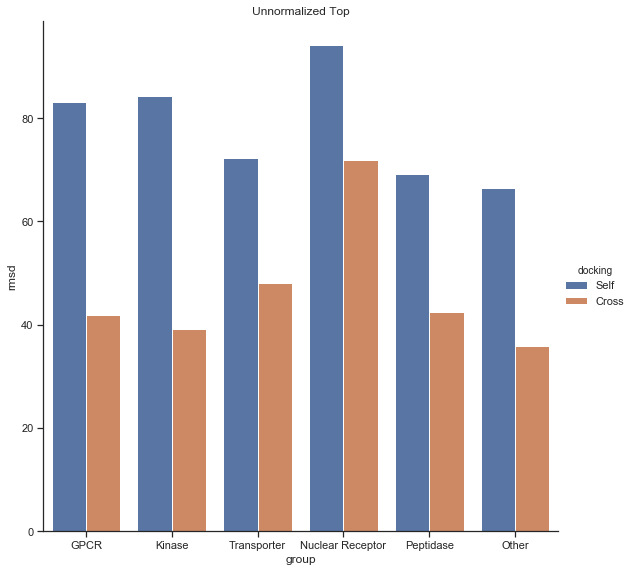

In [100]:
family = {
        'GPCR': ['5HT2B', 'A2AR', 'B1AR', 'B2AR', 'CHRM3','SMO', 'MGLUR5'],
        'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
        'Transporter': ['SLC6A4', 'GLUT1', 'DAT'],
        'Nuclear Receptor': ['NR3C2', 'NR3C1', 'AR', 'VDR', 'ERA'],
        'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
        'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1', 'ELANE', 'TRPV1', 'DHFR']
        }
unnormalized_top_group_graph_rmsds = []

for group in family:
    self_counter = 0
    cross_counter = 0
    self_docking_count = 0
    cross_docking_count = 0
    
    for protein in family[group]:
        for struc in rmsds[protein]:
            for ligand in rmsds[protein][struc]:
                if rmsds[protein][struc][ligand] == None or rmsds[protein][struc][ligand] == []:
                    continue
                rmsd = rmsds[protein][struc][ligand][0]
                if ligand == struc:
                    self_counter += 1
                    if rmsd < 2:
                        self_docking_count += 1
                else:
                    cross_counter += 1
                    if rmsd < 2:
                        cross_docking_count += 1
    unnormalized_top_group_graph_rmsds.append([group, self_docking_count * 100 / self_counter, 'Self'])
    unnormalized_top_group_graph_rmsds.append([group, cross_docking_count * 100 / cross_counter, 'Cross'])
        
df = pd.DataFrame(unnormalized_top_group_graph_rmsds)
df.columns= ['group', 'rmsd', 'docking']
g = sns.catplot(x='group', y='rmsd', hue='docking', data=df, kind="bar", height=8)
plt.title('Unnormalized Top')
plt.show()

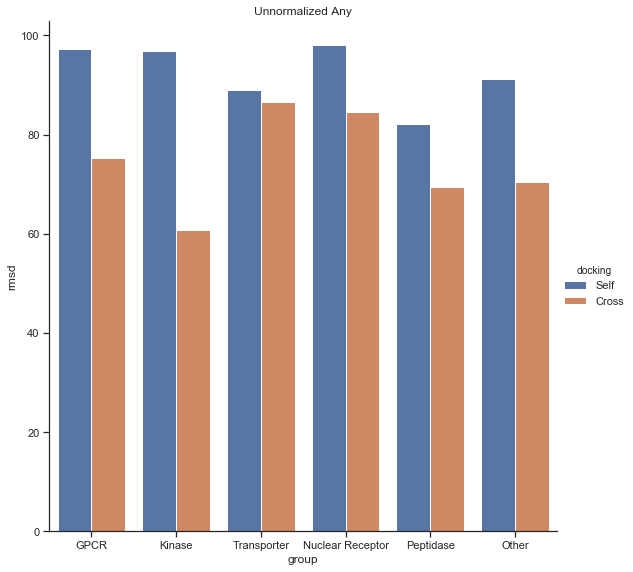

In [102]:
family = {
        'GPCR': ['5HT2B', 'A2AR', 'B1AR', 'B2AR', 'CHRM3','SMO', 'MGLUR5'],
        'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
        'Transporter': ['SLC6A4', 'GLUT1', 'DAT'],
        'Nuclear Receptor': ['NR3C2', 'NR3C1', 'AR', 'VDR', 'ERA'],
        'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
        'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1', 'ELANE', 'TRPV1', 'DHFR']
        }
unnormalized_any_group_graph_rmsds = []

for group in family:
    self_counter = 0
    cross_counter = 0
    self_docking_count = 0
    cross_docking_count = 0
    
    for protein in family[group]:
        for struc in rmsds[protein]:
            for ligand in rmsds[protein][struc]:
                if rmsds[protein][struc][ligand] == None or rmsds[protein][struc][ligand] == []:
                    continue
                rmsd = min(rmsds[protein][struc][ligand])
                if ligand == struc:
                    self_counter += 1
                    if rmsd < 2:
                        self_docking_count += 1
                else:
                    cross_counter += 1
                    if rmsd < 2:
                        cross_docking_count += 1
    unnormalized_any_group_graph_rmsds.append([group, self_docking_count * 100 / self_counter, 'Self'])
    unnormalized_any_group_graph_rmsds.append([group, cross_docking_count * 100 / cross_counter, 'Cross'])
        
df = pd.DataFrame(unnormalized_any_group_graph_rmsds)
df.columns= ['group', 'rmsd', 'docking']
g = sns.catplot(x='group', y='rmsd', hue='docking', data=df, kind="bar", height=8)
plt.title('Unnormalized Any')
plt.show()

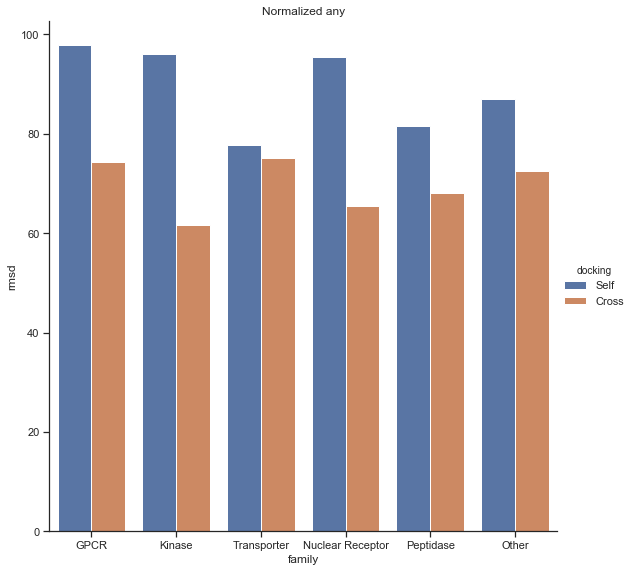

In [95]:
df = pd.DataFrame(normalized_any_group_graph_rmsds)
df.columns= ['family', 'rmsd', 'docking']
g = sns.catplot(x='family', y='rmsd', hue='docking', data=df, kind="bar", height=8)
plt.title('Normalized any')
plt.show()